### importações

In [2]:
import os
import tensorflow as tf
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw, ImageFilter
import glob

cwd = os.getcwd()

BATCH_SIZE = 64
EPOCH_SIZE = 64


### gerar imagens

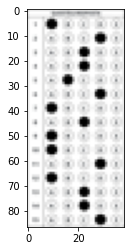

In [4]:
def gabarito_gen(batch_size = 64):
    # pasta das imagens de gabaritos
    source_path = cwd + "\\tests\\"
    image_files = [f for f in glob.glob(source_path + '*.png')]

    while True:
        # gerando imagens pretas no tamanho desejado
        X = np.zeros((batch_size, 256, 192, 3))
        Y = np.zeros((batch_size, 3))

        # preenchendo imagens
        for i in range(batch_size):
            for filepath in image_files:
                # lendo imagem e fazendo resize para (64, 64) e depois convertendo para array de numpy
                gabarito = Image.open(filepath)
                gabarito = gabarito.resize((39, 87))
                imgGabarito = np.asarray(gabarito)
                plt.imshow(imgGabarito)

                # resize no gabarito
                # size = np.random.randint(32, 64)
                temp_gabarito = gabarito.resize((39, 87))#(size, size)
                imgGabarito = np.asarray(temp_gabarito) / 255.
                gabarito_x, gabarito_y, _ = imgGabarito.shape

                # criar fundo preto da imagem
                bg = Image.new('RGB', (192, 256))

                # processo de geracao
                x1 = np.random.randint(1, 256 - gabarito_x)
                y1 = np.random.randint(1, 192 - gabarito_y)

                # colar imagem do gabarito sobre o fundo preto
                bg.paste(temp_gabarito, (x1, y1))
                # transformando em array de numpy
                gabarito = np.asarray(bg) / 255.
                X[i] = gabarito

                Y[i, 0] = x1 / 256.
                Y[i, 1] = y1 / 192.
                Y[i, 2] = gabarito_x / 256.
        yield X, Y

# chamando funcao de gerar gabaritos
x, y = next(gabarito_gen())

64


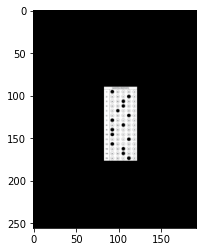

In [6]:
# teste de plotagens
print(len(x))
plt.imshow(x[9])

### buscar imagens geradas

### transferencia de aprendizado - lendo VGG pre-treinada e substituindo cabeçalho

In [7]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

vgg = tf.keras.applications.VGG16(input_shape=[192, 256, 3], include_top=False, weights='imagenet')
x = Flatten()(vgg.output)
x = Dense(3, activation='sigmoid')(x)
model2 = Model(vgg.input, x)
model2.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.001))
model2.summary()


Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 256, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 192, 256, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 192, 256, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 96, 128, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 96, 128, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 96, 128, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 48, 64, 128)      

### fazendo augumentation das imagens

In [102]:
# aug = ImageDataGenerator(rotation_range=20, zoom_range=0.15,
# 	width_shift_range=0.2, height_shift_range=0.2, shear_range=0.15,
# 	horizontal_flip=True, fill_mode="nearest")

# aug.flow(x, y, BATCH_SIZE)

### treinando modelo

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
64/64 [==============================] - 2766s 43s/step - loss: 0.6609
Epoch 2/5
64/64 [==============================] - 2974s 46s/step - loss: 0.5779
Epoch 3/5
64/64 [==============================] - 3250s 51s/step - loss: 0.5751
Epoch 4/5
64/64 [==============================] - 3236s 51s/step - loss: 0.5783
Epoch 5/5
64/64 [==============================] - 3102s 48s/step - loss: 0.5788


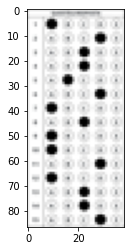

In [8]:
model2.fit_generator(gabarito_gen(), steps_per_epoch = EPOCH_SIZE, epochs = 5)

In [9]:
model2.save_weights('v1')

### predizer a posição do gabarito na imagem

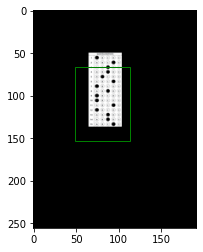

In [17]:
def plot_pred(img, p):
  fig, ax = plt.subplots(1)
  ax.imshow(img)
  rect = Rectangle(xy = (p[0] * 192, p[1] * 256), width = p[2] * 192, height = p[2] * 256, linewidth = 1,edgecolor = 'g',facecolor = 'none')
  ax.add_patch(rect)
  plt.show()

# gerar imagem de teste
X = np.zeros((64, 192, 256, 3))
gabarito = Image.open('tests/blog (1).png')
gabarito = gabarito.resize((39, 87))

bg = Image.new('RGB', (192, 256))
# bg.paste(gabarito, (0, 0))
bg.paste(gabarito, (65, 50))
gabarito = np.asarray(bg) / 255.
X = gabarito
X = np.expand_dims(X, axis=0)
# x, _ = next(gabarito_gen())
# print(x.shape)
# print(x[0].shape)
# print(X.shape)
# plt.imshow(X[0])
pred = model2.predict(X)
plot_pred(X[0], pred[0])

# print(pred)
# img = x[50]
# p = pred[50]
# plot_pred(bg, pred)